In [1]:
#Import Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py 
py.init_notebook_mode(connected=True)                  
import plotly.graph_objs as go                         
import plotly.tools as tls                             
from collections import Counter                        
import plotly.figure_factory as ff

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [2]:
#read data and get roughly info of data
data = pd.read_csv('amazon_alexa.tsv',sep="\t")
print(data.head())
print('--------------\n')
print(data.shape)
print('--------------\n')
data.info()

   rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback  
0                                      Love my Echo!         1  
1                                          Loved it!         1  
2  Sometimes while playing a game, you can answer...         1  
3  I have had a lot of fun with this thing. My 4 ...         1  
4                                              Music         1  
--------------

(3150, 5)
--------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         31

In [3]:
#how many Alexa products in the data, and details of them?
print(data['variation'].nunique())
print('------------\n')
print(data['variation'].value_counts())
data.groupby('variation').agg({'rating':'mean'}).sort_values('rating',ascending = False).head()

16
------------

Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
White                            91
Sandstone Fabric                 90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: variation, dtype: int64


,rating
variation,
Walnut Finish,4.888889
Oak Finish,4.857143
Charcoal Fabric,4.730233
Heather Gray Fabric,4.694268
Configuration: Fire TV Stick,4.591429


In [4]:
#how many feedbacks we received, and their contribution?
print(data['feedback'].value_counts())

1    2893
0     257
Name: feedback, dtype: int64


In [5]:
# EDA , data visulaization
#how many positive and negative feedbacks for each products
positive_feedback=data[data['feedback']==1]
negative_feedback = data[data['feedback']==0]

trace0=go.Bar(
            x=positive_feedback['variation'].value_counts().index.values,
            y=positive_feedback['variation'].value_counts().values,
            name='Good Feedbacks')
trace1=go.Bar(
            x=negative_feedback['variation'].value_counts().index.values,
            y=negative_feedback['variation'].value_counts().values,
            name = "Bad Feedbacks")
bars=[trace0,trace1]
fig=go.Figure(data=bars)
py.iplot(fig)

(0.0, 2514.6000000000004)

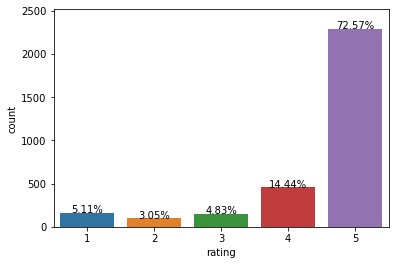

In [6]:
# more about the rating from customers
g=sns.countplot(x='rating',data=data)
sizes=[]
for p in g.patches:
    height=p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
    height +3,
    '{:1.2f}%'.format(height/len(data) *100),
    ha='center',fontsize=10)
g.set_ylim(0,max(sizes)*1.1)

In [7]:
# Encoding
variation_dummies = pd.get_dummies(data['variation'],drop_first=True)
variation_dummies.head()

,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,Walnut Finish,White,White Dot,White Plus,White Show,White Spot
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [8]:
data.drop(['variation','rating','date'],axis=1,inplace=True)
data.head()

,verified_reviews,feedback
0,Love my Echo!,1
1,Loved it!,1
2,"Sometimes while playing a game, you can answer...",1
3,I have had a lot of fun with this thing. My 4 ...,1
4,Music,1


In [9]:
data=pd.concat([data,variation_dummies],axis=1)
data.head()

,verified_reviews,feedback,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,Walnut Finish,White,White Dot,White Plus,White Show,White Spot
0,Love my Echo!,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Loved it!,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,"Sometimes while playing a game, you can answer...",1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,I have had a lot of fun with this thing. My 4 ...,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Music,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [11]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer()
alexa_countvectorizer = vectorizer.fit_transform(data['verified_reviews'])
print(alexa_countvectorizer.toarray())
data.drop(['verified_reviews'],axis=1,inplace=True)
data.head()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


,feedback,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,Walnut Finish,White,White Dot,White Plus,White Show,White Spot
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [12]:
encoded_reviews=pd.DataFrame(alexa_countvectorizer.toarray())
encoded_reviews.head()

,0,1,2,3,4,5,6,7,8,9,...,4034,4035,4036,4037,4038,4039,4040,4041,4042,4043
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
data = pd.concat([data,encoded_reviews],axis=1)
data.head()

,feedback,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,...,4034,4035,4036,4037,4038,4039,4040,4041,4042,4043
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Modeling, split tranning and testing with std 0.67;0.33
X_train, X_test, Y_train, Y_test = train_test_split(data.drop(['feedback'],axis=1),data['feedback'],test_size=0.67,random_state=345)
X_train.shape, X_test.shape,Y_train.shape,Y_test.shape

((1039, 4059), (2111, 4059), (1039,), (2111,))

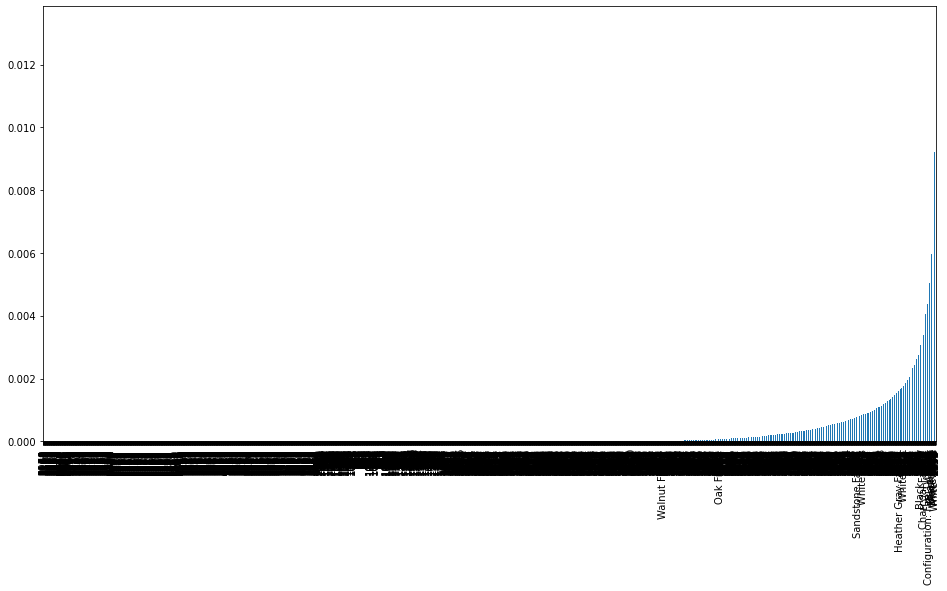

In [28]:
#feature importance
#rf=RandomForestClassifier(n_estimators=100, max_features=3)
#rf.fit(X_train,Y_train)
#feature_importances=pd.Series(rf.feature_importances_,index=data.drop(['feedback'],axis=1).columns)
#fig = plt.figure(figsize=(16,8))
#feature_importances.sort_values().plot(kind='bar')
#plt.show()

In [31]:
#Model Tuning
rf_params={"n_estimators":[100,200,500,1000],
          "max_features":[3,5,7],
          "min_samples_split":[2,5,10,30],
          "max_depth":[3,5,8,None]}
rf_model= RandomForestClassifier(random_state=357)
rf_cv_model=GridSearchCV(rf_model,rf_params,cv=10,n_jobs=-1,verbose=1).fit(X_train,Y_train)
rf_tuned=RandomForestClassifier(**rf_cv_model.best_params_).fit(data.drop(['feedback'],axis=1),data['feedback'])

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed: 26.9min finished


In [32]:
tuned=[rf_tuned]
print("Best Model Parameters and Scores :")
for i in tuned:
    score=cross_val_score(i, X_train, Y_train,cv=10).mean()
    print(i,"score :", score)

Best Model Parameters and Scores :
RandomForestClassifier(max_features=3, min_samples_split=5, n_estimators=500) score : 0.9278192681105303


In [38]:
from sklearn.metrics import confusion_matrix
rf=RandomForestClassifier(n_estimators=500, max_features=3,oob_score=True)
rf.fit(X_train,Y_train)
print("The OOB accurancy is ",
     rf.oob_score_)
print("OOB confusion matrix is ","\n",
     pd.DataFrame(confusion_matrix(Y_train, rf.oob_decision_function_[:,1].round(),labels=[0,1])))

The OOB accurancy is  0.9278152069297402
OOB confusion matrix is  
    0    1
0  4   72
1  3  960


In [44]:
#Validating by testing data
#print( 'The OOB accurancy for TEST is ',"\n",
      rf.score(X_test,Y_test),"\n",
      "The OOB confusion matrix for TEST is ", "\n",
      pd.DataFrame(confusion_matrix(Y_test,rf.predict(X_test),labels=[0,1])
     )

SyntaxError: unexpected EOF while parsing (<ipython-input-44-60bae8102720>, line 6)